In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import os

warnings.filterwarnings("ignore")
sns.set()

In [2]:
DATA_PATH = "."

train_towers = pd.read_csv(os.path.join(DATA_PATH, "train_towers.csv"))
train_geo = pd.read_csv(os.path.join(DATA_PATH, "train_geo.csv"))
test_towers = pd.read_csv(os.path.join(DATA_PATH, "test_towers.csv"))
test_geo = pd.read_csv(os.path.join(DATA_PATH, "test_geo.csv"))

train_towers.head()

,Скважина,Дата,Характер работы,Состояние,"Время работы, ч","Нефть, т","Вода, т","Жидкость, т","Попутный газ, м3","Закачка, м3",...,Р пл,Р заб расчётное,Потери давления на трение,Р затр,Р уст,Закачка за месяц,Рпл,k,Р уст.1,Р заб
0,101,12/1/2016,НЕФ,РАБ.,744,"186,44","241,84","428,28",7820,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,102,12/1/2016,НАГ,РАБ.,744,0,0,0,0,2096,...,258.0,436.472966,1.162974,195.0,196.0,2190.0,0.0,3.271276,196.0,430.412299
2,103,12/1/2016,НЕФ,РАБ.,744,"554,09","399,36","953,45",23241,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,104,12/1/2016,НЕФ,РАБ.,744,"225,65","351,29","576,94",9465,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,105,12/1/2016,НЕФ,РАБ.,744,"953,7","284,71","1238,41",40002,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
train_geo.head()

,№ скважины,Координата X,Координата Y
0,101,6622056,504780
1,102,6621645,504916
2,103,6621857,504372
3,104,6621436,504586
4,105,6621585,505642


In [4]:
train = pd.merge(train_towers, train_geo, left_on="Скважина", right_on="№ скважины")
train = train.rename(columns={"Координата X": "geo_x", "Координата Y": "geo_y"})
#train = train.rename(columns={
#    "Состояние": "condition",
#    "Характер работы": "type",
#    "Нефть, т": "oil",
#    "Вода, т": "water",
#    "Жидкость, т": "liquid",
#})
train = train.drop("№ скважины", axis=1)
train.head()

,Скважина,Дата,Характер работы,Состояние,"Время работы, ч","Нефть, т","Вода, т","Жидкость, т","Попутный газ, м3","Закачка, м3",...,Потери давления на трение,Р затр,Р уст,Закачка за месяц,Рпл,k,Р уст.1,Р заб,geo_x,geo_y
0,101,12/1/2016,НЕФ,РАБ.,744,"186,44","241,84","428,28",7820,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6622056,504780
1,101,11/1/2016,НЕФ,РАБ.,720,"235,45","193,7","429,14",9884,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6622056,504780
2,101,10/1/2016,НЕФ,РАБ.,744,"247,8","190,08","437,87",10502,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6622056,504780
3,101,9/1/2016,НЕФ,РАБ.,720,"280,39","189,92","470,31",12203,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6622056,504780
4,101,8/1/2016,НЕФ,РАБ.,744,"319,35","208,11","527,47",13740,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6622056,504780


In [5]:
oil_df = train[train['Агент закачки'].notnull()][train['Состояние'] == 'РАБ.'].copy()
water_df = train[train['Агент закачки'].isnull()][train['Состояние'] == 'РАБ.'].copy()

def remove_bad_cols(df):
    bad_cols = []

    for col in df.columns:
        has_nan = any(df[col].isnull())
        unique_values = df[col].nunique()
    
        if has_nan and unique_values == 1:
            print(f"Column {col} has NaN values - {unique_values}")
            bad_cols.append(col)
            
    df = df.drop(bad_cols, axis=1)
            
    return df, bad_cols

def get_target_cols(df):
    oil_targets = [
        'Нефть, т',
        'Нефть, м3',
        'Вода, т',
        'Жидкость, т',
        'Жидкость, м3',
        'Попутный газ, м3',
        'Обводненность (вес), %',
        'Обводненность'
    ]
            
    return oil_targets

def get_closest_water_towers(df, date, x_col, y_col):
    cols = ['Скважина', x_col, y_col]
    nef = df[df.type == 'НЕФ'][df['Дата'] == date]
    wat = df[df.type == 'НАГ'][df['Дата'] == date]
    
    tower_mapping = {} 

    for tower in nef[cols].drop_duplicates().values:
        id = tower[0]
        x = tower[1]
        y = tower[2]
    
        distances = []
    
        for wat_tower in wat[cols].drop_duplicates().values:
            w_id = wat_tower[0]
            w_x = wat_tower[1]
            w_y = wat_tower[2]
        
            distance = np.sqrt((x - w_x) ** 2 + (y - w_y) ** 2)
            distances.append((distance, w_id))
            
        tower_mapping[id] = distances
        
    tower_mapping = {name: sorted(distances)[:3] for name, closest in tower_mapping.items()}
    
    return tower_mapping

In [413]:
oil_df, bad_cols = remove_bad_cols(oil_df)
water_df, w_bad_cols = remove_bad_cols(water_df)

targets = get_target_cols(train)

unused_cols = [
    "Скважина",
    "Дата",
    "Характер работы",
    "Состояние",
    "Буферное давление",
    "Давление в линии",
    "Удл",
    'Р затр',
    "geo_x",
    "geo_y"
] + target_cols

feature_cols = [col for col in oil_df.columns if col not in unused_cols]
categorical_cols = list(oil_df[feature_cols].select_dtypes(include=["object"]).columns)

for col in categorical_cols:
    print(f"Category - {col} - {oil_df[col].nunique()} unique")
    
float_cols = [
    'Давление на приеме',
    'Забойное давление',
    'Замерное забойное давление',
    'Динамическая высота'
]

categorical_cols = [col for col in categorical_cols if col not in float_cols]

for col in float_cols:
    oil_df[col] = oil_df[col].astype("float")
    
feature_cols

Category - Агент закачки - 12 unique
Category - Тип скважины - 2 unique
Category - Удлинение - 25 unique
Category - Затрубное давление - 23 unique
Category - Состояние на конец месяца - 2 unique


['Время работы, ч',
 'Закачка, м3',
 'Агент закачки',
 'Тип скважины',
 'Диаметр НКТ',
 'Диаметр штуцера',
 'Глубина верхних дыр перфорации',
 'Удлинение',
 'Производительность ЭЦН',
 'Напор',
 'Частота',
 'Глубина спуска',
 'Пластовое давление',
 'Динамическая высота',
 'Затрубное давление',
 'Давление на приеме',
 'Забойное давление',
 'Состояние на конец месяца',
 'Газовый фактор',
 'Вязкость жидкости в пласт. условиях',
 'Дата ввода в эксплуатацию',
 'Замерное забойное давление',
 'Дата перевода в ППД',
 'Н вд',
 'Н нд',
 'D э/к',
 'D нкт',
 'Н сп',
 'Приемистость',
 'Р пл',
 'Р заб расчётное',
 'Потери давления на трение',
 'Р уст',
 'Закачка за месяц',
 'Рпл',
 'k',
 'Р уст.1',
 'Р заб']

In [306]:
categorical_cols

['Агент закачки',
 'Тип скважины',
 'Удлинение',
 'Затрубное давление',
 'Состояние на конец месяца']

In [361]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

target = target_cols[0]

X = oil_df[feature_cols].copy()
y = oil_df[target].copy()

y = y.astype("str").apply(lambda x: x.replace(",", "."))
y = y.apply(lambda x: x.replace(" ", "")).astype("float")

enc = LabelEncoder()
for col in categorical_cols:
    print(f"Encoding {col}")
    X[col] = X[col].fillna("")
    X[col] = enc.fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Encoding Агент закачки
Encoding Тип скважины
Encoding Удлинение
Encoding Затрубное давление
Encoding Состояние на конец месяца


In [364]:
model = GradientBoostingRegressor()
model.fit(X_train.fillna(0), y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [373]:
from sklearn.metrics import mean_absolute_error

y_pred = model.predict(X_test.fillna(0))
err = mean_absolute_error(y_test, y_pred) / y_test.max() * 100
err

0.2666327663568649

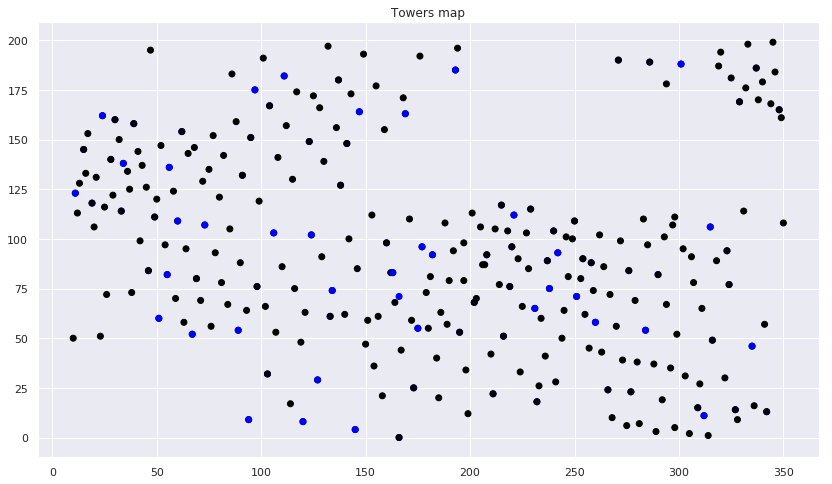

In [207]:
coords = pd.read_csv('towers_map.csv')

def fix_y_coords(x):
    if x >= 150:
        x = x - 200
        
    return x

coords.geo_y = coords.geo_y.apply(fix_y_coords)
coords.geo_x = (coords.geo_x * 1.3 + 10).astype("int")
coords.geo_y = (coords.geo_y + 50).astype("int")

plt.figure(figsize=(14,8))
plt.scatter(coords["geo_x"], coords["geo_y"], c=coords["color"])
plt.title("Towers map")
plt.show()

In [208]:
print(list(coords.geo_y))

[50, 123, 123, 113, 128, 145, 145, 133, 153, 118, 118, 106, 131, 51, 162, 162, 116, 72, 140, 140, 122, 160, 160, 150, 114, 114, 138, 138, 134, 125, 73, 158, 158, 144, 99, 137, 126, 84, 84, 195, 111, 111, 120, 60, 60, 147, 97, 82, 82, 136, 136, 124, 70, 109, 109, 154, 154, 58, 95, 143, 52, 52, 146, 80, 80, 69, 129, 107, 107, 135, 56, 152, 93, 121, 78, 142, 67, 105, 183, 159, 54, 54, 88, 132, 132, 64, 9, 9, 151, 151, 175, 175, 76, 76, 119, 191, 66, 32, 32, 167, 167, 103, 103, 53, 141, 86, 182, 182, 157, 17, 130, 75, 174, 48, 8, 8, 63, 149, 149, 102, 102, 172, 29, 29, 166, 91, 139, 197, 61, 61, 74, 74, 156, 180, 180, 127, 127, 62, 148, 148, 100, 173, 4, 4, 85, 164, 164, 193, 47, 59, 112, 36, 177, 61, 21, 155, 98, 98, 83, 83, 83, 68, 71, 0, 0, 44, 171, 163, 163, 110, 59, 25, 25, 55, 55, 192, 96, 96, 73, 55, 81, 92, 92, 40, 20, 63, 108, 57, 79, 94, 185, 185, 196, 53, 53, 79, 98, 34, 12, 113, 68, 68, 70, 106, 87, 87, 92, 92, 42, 22, 22, 105, 77, 117, 117, 51, 51, 104, 76, 76, 96, 96, 112, 11

In [176]:
cols = ['Дата', 'Скважина', 'Обводненность']

output = train[cols][train['Дата'] == '12/1/2016'].drop_duplicates().fillna(0)[['Скважина', 'Обводненность']]
output.columns = ['label', 'water']

print(list(output.water))

['40.0', 0, '33.0', '50.0', '18.0', '19.0', '30.0', 0, '50.0', 0, 0, '31.0', '20.0', 0, 0, 0, 0, '26.0', '20.0', 0, 0, 0, '49.0', '34.0', 0, 0, '40.0', 0, 0, 0, 0, '28.0', 0, 0, 0, '57.09', '27.0', '19.0', 0, 0, '69.0', '56.0', '83.0', 0, '27.0', 0, '20.0', '23.0', '64.0', 0, 0, 0, 0, 0, '34.0', '14.0', '15.0', '14.0', 0, '90.0', 0, '31.0', 0, '76.0', '79.0', '8.0', '15.0', 0, 0, 0, '78.0', '60.0', '47.0', '28.0', '40.0', 0, '33.0', 0, 0, '91.0', 0, '52.0', 0, 0, 0, 0, '70.0', 0, '60.0', '59.0', '33.0', 0, '84.0', '47.0', '38.0', 0, '50.0', 0, 0, 0, 0, '83.0', '66.0', 0, 0, '64.0', '94.0', 0, 0, 0, 0, '84.0', 0, '58.0', 0, 0, 0, 0, '82.0', '91.0', '50.0', 0, '60.0', '50.0', 0, 0, '71.0', 0, '36.0', '85.0', '46.0', 0, 0, 0, 0, '62.0', '71.0', '43.0', '93.0', 0, '88.0', '62.0', '82.0', 0, '35.0', '88.0', 0, 0, '50.0', '73.0', 0, 0, '24.0', '77.0', 0, 0, '25.0', '29.0', 0, 0, '60.0', '60.0', 0, '69.0', '61.0', '85.0', 0, 0, 0, 0, 0, 0, '77.0', 0, '70.0', 0, 0, '60.0', 0, 0, '84.0', '78.0'

In [6]:
target = 'Нефть, т'

oil_df[target] = oil_df[target].astype('str').apply(lambda s: s.replace(",", ".")).astype("float")
oil_df[target].unique()

array([  0.  , 152.25,  64.  , 187.44, 107.  , 750.  , 584.  ,  59.  ,
        23.  ,  24.  , 417.71, 319.  ,   6.55, 613.  ,  12.  ,  83.  ,
       331.  , 234.  , 165.  , 309.  , 148.  ,  50.  ,  33.  ,   8.  ,
         2.  , 344.  ,  81.  , 766.  , 376.  , 397.  , 156.  , 250.  ,
       102.  , 120.  , 399.  , 113.  ,  98.  ,  52.  ,  72.  ,  58.  ,
       174.  ,  14.  , 135.  ,  39.  , 222.61, 180.34, 138.69,  58.35,
       507.  ])

In [7]:
oil_df["year"] = oil_df['Дата'].apply(lambda s: s.split("/")[2])
target_cols = ["year", target]

output_df = oil_df[target_cols].sort_values(by=["year"])
output_df = output_df.groupby("year")[target].sum()
output_df

year
2008     165.00
2009    1304.00
2010    1527.00
2011    2200.00
2012     716.00
2013    1869.00
2014     831.71
2015     599.99
2016     346.24
Name: Нефть, т, dtype: float64

In [13]:
import json
output = [{"labels": list(output_df.index), "data": list(output_df.values + 150)}]
json.dumps(output)

'[{"labels": ["2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016"], "data": [315.0, 1454.0, 1677.0, 2350.0, 866.0, 2019.0, 981.71, 749.99, 496.24]}]'

In [40]:
preds = pd.read_csv('predictions_with_data.csv').drop('Unnamed: 0', axis=1)
preds.head()

,Скважина_x,Дата_x,prediction_whater_mean,prediction_neft
0,101,01.12.2016,1832.784904,412.578685
1,103,01.12.2016,1832.784904,519.450882
2,104,01.12.2016,1832.784904,381.339403
3,105,01.12.2016,1832.784904,744.110913
4,107,01.12.2016,1832.784904,1034.803023


In [68]:
def fix_date(dt):
    day, month, year = dt.split("-")
    
    return f"{year}-{month}-{day}"

cols = ['Дата_x', 'prediction_neft']

df.columns = ['Дата', 'pred_neft']
df['Дата'] = df['Дата'].apply(lambda s: s.replace(".", "-"))
df['Дата'] = df['Дата'].apply(fix_date)

cols = ['Дата', 'pred_neft']
preds = df[cols].drop_duplicates().sort_values(by=['Дата'], ascending=True)

pred_stat = df[cols].groupby('Дата')['pred_neft'].sum()

In [72]:
df[df['Дата'] == '2016-12-01'].pred_neft.sum()

84632.99223230893

In [74]:
t_df[t_df['Дата'] == '2016-12-01'].true_neft.sum()

0.0

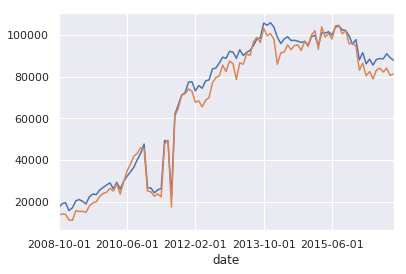

In [178]:
stat = pd.read_csv('~/Downloads/predict_and_real_oil.csv')
stat = stat.rename(columns={'Дата_x': 'date'})

stat.date = stat.date.apply(lambda s: s.replace(".", "-"))
stat.date = stat.date.apply(fix_date)

pred_col = 'prediction_neft'

cols = ['date', true_col, pred_col]

stat = stat.sort_values(by=['date'])
pred_stat = stat.groupby('date')[pred_col].sum()
true_stat = stat.groupby('date')[true_col].sum()

med = pred_stat.median() * 0.042
noise = np.random.randint(low=-700, high=4000)
pred_stat = pred_stat + noise

pred_stat.plot()
true_stat.plot()
plt.show()

In [186]:
print(list(stat[true_col].astype("int")))

[13378, 14149, 13890, 11264, 11023, 15663, 15337, 15397, 14896, 18057, 19442, 19948, 22556, 23971, 24493, 26448, 25086, 28709, 23656, 29407, 34650, 38098, 41835, 43209, 45935, 45362, 25099, 24736, 22587, 23747, 22272, 47647, 49557, 17496, 61147, 64850, 71140, 71817, 74104, 73015, 67741, 68369, 65487, 68731, 69921, 77013, 79588, 80408, 85523, 82419, 87498, 86335, 78671, 86710, 85938, 90811, 90239, 96781, 98931, 96342, 103151, 99658, 100673, 97939, 85914, 91401, 91845, 95288, 92934, 94954, 95226, 92546, 97080, 94430, 100004, 102073, 93180, 103906, 98998, 100753, 98062, 104350, 104737, 100563, 102165, 95769, 96035, 94662, 83121, 86442, 80435, 82474, 78920, 83170, 84085, 82235, 84135, 80679, 81336]


In [92]:
pred_stat.index[-1]

'2016-12-01'

In [198]:
print(list(train['Обводненность'].fillna(0).astype("float")))[:100]

ValueError: could not convert string to float: '18-мар.'

In [121]:
pred_stat[(pred_stat > true_stat)].count()

52

In [122]:
pred_stat[(pred_stat < true_stat)].count()

47